# Holiday Modeling Using Google Trends Data

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import matplotlib

import cmdstanpy
cmdstanpy.install_cmdstan()

Installing CmdStan version: 2.30.1
Install directory: /Users/daniel.marthaler/.cmdstan
CmdStan version 2.30.1 already installed


True

In [3]:
from cmdstanpy import CmdStanModel

In [156]:
from bayesian_holidays.src.holiday_model import fit_holiday_model
from bayesian_holidays.src.plot_utils import plot_posteriors

In [5]:
from bayesian_holidays.src.utils import (
    create_d_peak,
    create_mask_logistic,
    fourier_design_matrix,
    get_holiday_dataframe,
    create_stan_data
)

In [6]:
from pytrends.request import TrendReq

In [7]:
ptrends = TrendReq()

In [8]:
start_date_str = "2015-11-08"
end_date_str = "2022-11-08"

In [141]:
start_date = None
end_date = None

In [144]:
today = date.today()
end_date_str = str(today)
if start_date is None:
    start_date_str = str(today - timedelta(days=5 * 365))
else:
    start_date_str = str(start_date)

In [145]:
start_date_str + " " + end_date_str

'2017-11-16 2022-11-15'

In [10]:
ptrends.build_payload(["chocolate"], timeframe=start_date_str + ' ' + end_date_str)

In [12]:
df = ptrends.interest_over_time().drop(columns=['isPartial']).reset_index().rename(columns={'chocolate':'observed'})

In [155]:
df_xmas, fit_xmas = fit_holiday_model(
    "chocolate",
    start_date=start_date,
    train_split=80,
    num_chains=2,
    max_treedepth=10,
    adapt_delta=0.8
)


12:01:25 - cmdstanpy - INFO - created output directory: /Users/daniel.marthaler/dev/bayesian_holidays/notebooks/data
12:01:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

12:02:35 - cmdstanpy - INFO - CmdStan done processing.
12:02:35 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: gamma_lpdf: Random variable[9] is 0, but must be positive finite! (in '/Users/daniel.marthaler/dev/bayesian_holidays/bayesian_holidays/src/new_holiday_model.stan', line 188, column 4 to column 50)
Consider re-running with show_console=True if the above output is unclear!
12:02:35 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 14 divergent transitions (5.6%)
	Chain 2 had 24 divergent transitions (9.6%)
	Use function "diagnose()" to see further information.


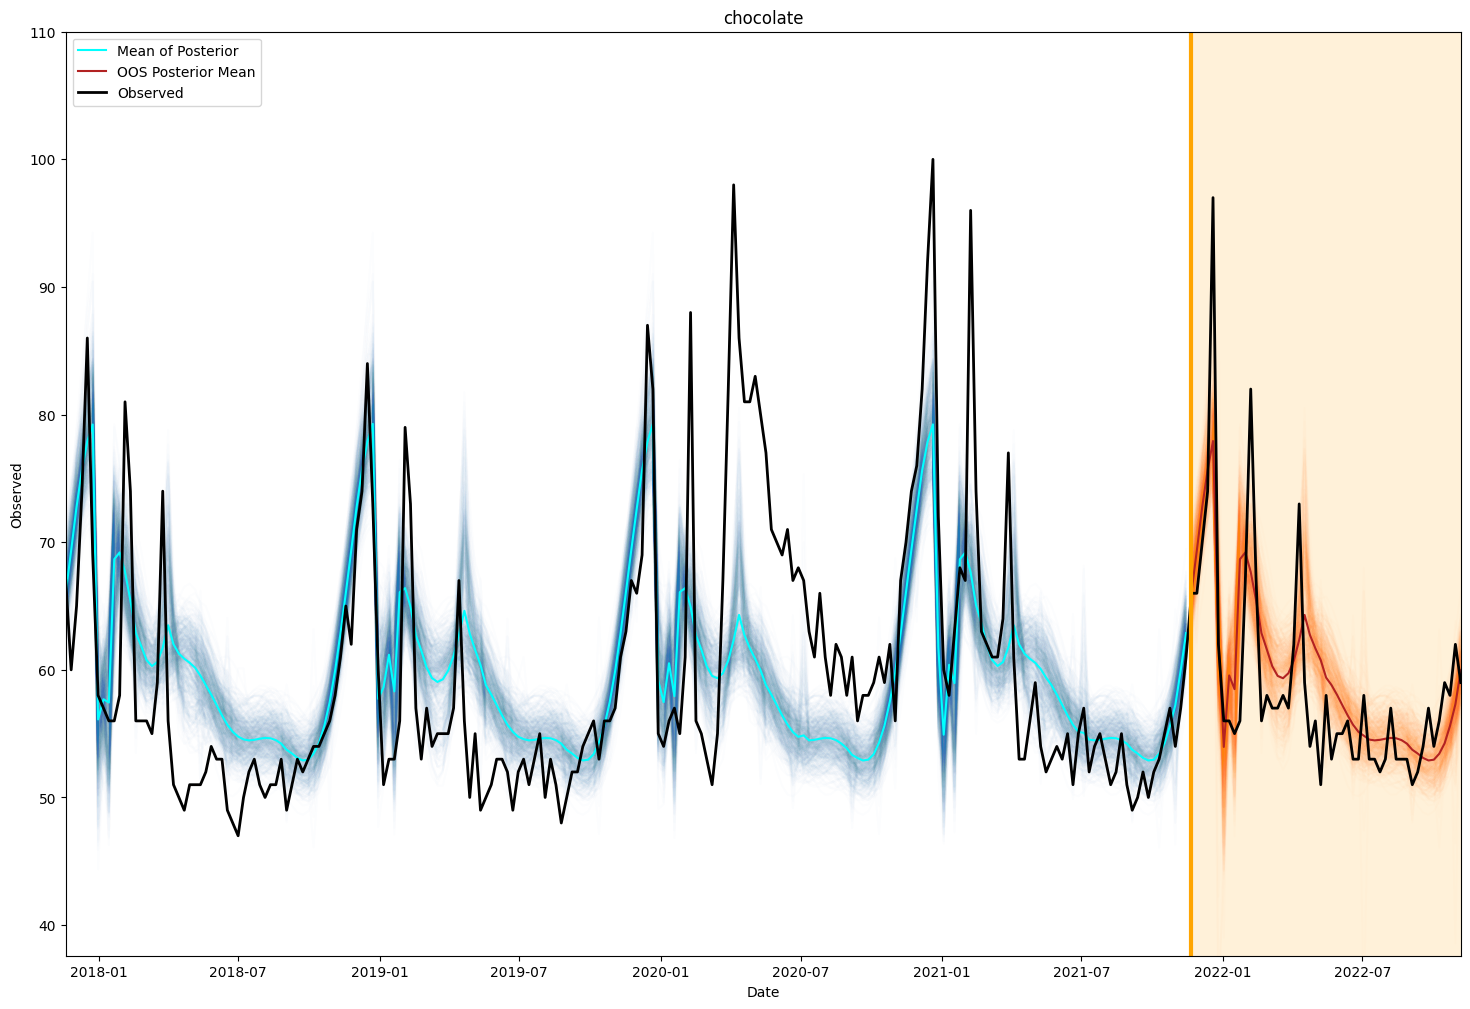

In [160]:
plot_posteriors(df_xmas, fit_xmas,"chocolate")

In [126]:
h_skew = df_fit.stan_variable("h_skew")
h_shape = df_fit.stan_variable("h_shape")
h_scale = df_fit.stan_variable("h_scale")
h_loc = df_fit.stan_variable("h_loc")
intensity = df_fit.stan_variable("intensity")

In [127]:
th = get_holiday_lift(h_skew, h_shape, h_scale, h_loc, intensity, d_peak_test, hol_mask_test)

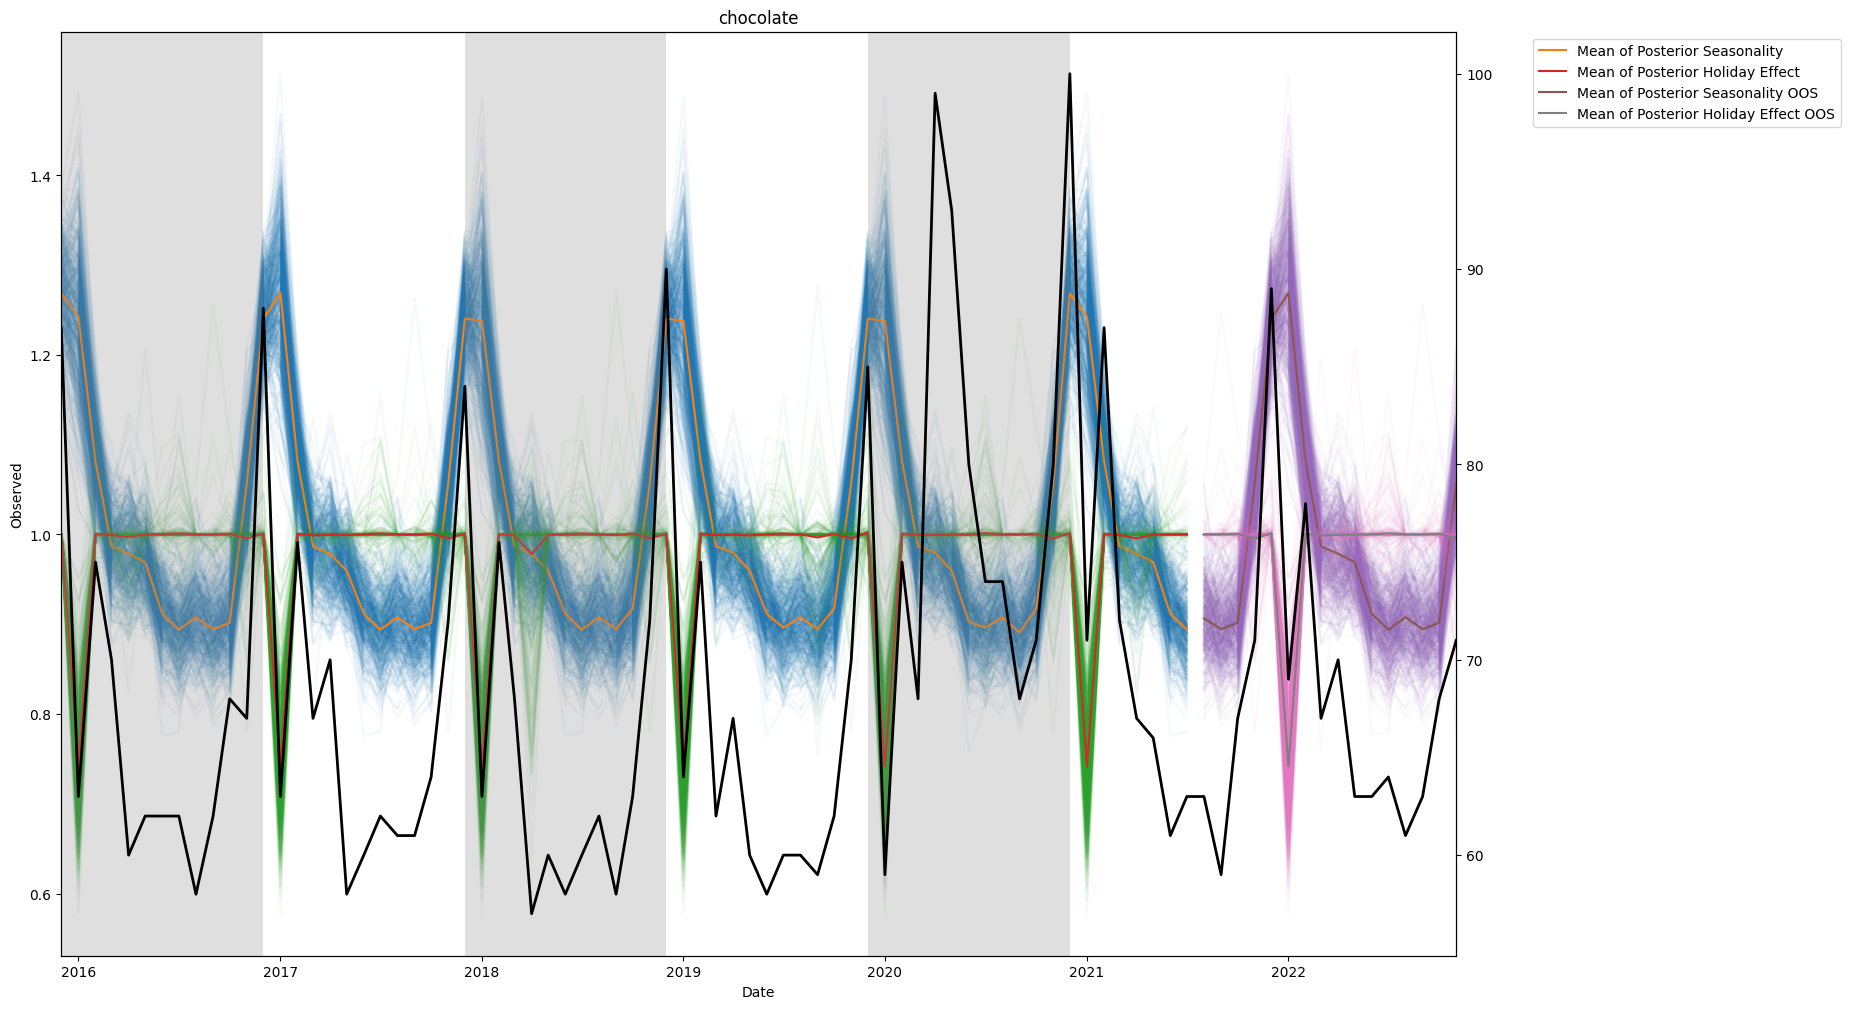

In [128]:
log_baseline = df_fit.stan_variable("log_baseline")
seasonality = df_fit.stan_variable("seasonality")
holiday_effect = df_fit.stan_variable("holiday_effect")

test_baseline = df_fit.stan_variable("test_log_baseline")
test_seasonality = df_fit.stan_variable("test_seasonality")
test_holiday_effect = df_fit.stan_variable("test_holiday_effect")

train_date = df.date.iloc[int(0.8 * df.shape[0])]

df_train = df[df.date <= train_date]
df_test = df[df.date > train_date]

fig, ax = plt.subplots(figsize=(18, 12))
if plot_train:
    p = ax.plot(df_train.date, np.exp(seasonality[0, :]), alpha=0.05)
    clr = p[0].get_color()
    for i in range(1, seasonality.shape[0]):
        ax.plot(df_train.date, np.exp(seasonality[i, :]), color=clr, alpha=0.05)
    ax.plot(
        df_train.date,
        np.exp(np.mean(seasonality, axis=0)),
        label="Mean of Posterior Seasonality",
    )
    p = ax.plot(df_train.date, np.exp(holiday_effect[0, :]), alpha=0.05)
    clr = p[0].get_color()
    for i in range(1, holiday_effect.shape[0]):
        ax.plot(df_train.date, np.exp(holiday_effect[i, :]), color=clr, alpha=0.05)
    ax.plot(
        df_train.date,
        np.exp(np.mean(holiday_effect, axis=0)),
        label="Mean of Posterior Holiday Effect",
    )
if plot_test:
    p = ax.plot(df_test.date, np.exp(test_seasonality[0, :]), alpha=0.05)
    clr = p[0].get_color()
    for i in range(1, test_seasonality.shape[0]):
        ax.plot(df_test.date, np.exp(test_seasonality[i, :]), color=clr, alpha=0.05)
    ax.plot(
        df_test.date,
        np.exp(np.mean(test_seasonality, axis=0)),
        label="Mean of Posterior Seasonality OOS",
    )
    p = ax.plot(df_test.date, np.exp(test_holiday_effect[0, :]), alpha=0.05)
    clr = p[0].get_color()
    for i in range(1, test_holiday_effect.shape[0]):
        ax.plot(
            df_test.date, np.exp(test_holiday_effect[i, :]), color=clr, alpha=0.05
        )
    ax.plot(
        df_test.date,
        np.exp(np.mean(test_holiday_effect, axis=0)),
        label="Mean of Posterior Holiday Effect OOS",
    )
ax1 = ax.twinx()
if plot_train and plot_test:
    ax1.plot(df.date, df.observed, label="Observed", lw=2, color="black")
    ax1.set_xlim(pd.to_datetime(start_date), df.date.max())
elif plot_train:
    ax1.plot(
        df_train.date, df_train.observed, label="Observed", lw=2, color="black"
    )
    ax1.set_xlim(pd.to_datetime(start_date), df_train.date.max())
elif plot_test:
    ax1.plot(df_test.date, df_test.observed, label="Observed", lw=2, color="black")
ax.set_xlabel("Date")
ax.set_ylabel("Observed")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
for i in range(0, 5, 2):
    plt.axvspan(
        pd.to_datetime(start_date) + i * pd.offsets.DateOffset(years=1),
        pd.to_datetime(start_date) + (i + 1) * pd.offsets.DateOffset(years=1),
        facecolor="gray",
        alpha=0.25,
    )
if name is not None:
    plt.title(name)
plt.show()

In [134]:
from datetime import date, timedelta

In [136]:
date.today() - timedelta(days=5*365)

datetime.date(2017, 11, 16)

In [131]:
date_str = str(date.today())

In [132]:
date_str


'2022-11-15'